## Linear function: signature + fourier

Notation

`X_path`: a collection of path $\mathcal{X}=\{x^{(1)}, x^{(2)}, \dots, x^{(R)}\}\in \mathbb{R}^{R\times n}$ (assuming each sample $x^{(i)}\in \mathbb{R}^{1\times n}$ is a row vector)

In [104]:
import numpy as np
import torch
from torch.utils.data import Dataset
from fbm import FBM
import iisignature
import matplotlib.pyplot as plt
import tqdm

In [105]:
def fbm_data_generator(sample_num, n, hurst):
    f = FBM(n=n-1, hurst=hurst)
    data = np.zeros((sample_num, n))
    for i in range(sample_num):
        data[i] = f.fbm()
    return torch.tensor(data)

def fft(path, f_depth=None, dt=None):
    freq_path = torch.fft.fft(path.T, dim=0)
    N = len(freq_path)
    n_oneside = N//2 + 1
    if f_depth and f_depth < n_oneside:
        n_oneside = f_depth
    # get the one side frequency
    freq_path_oneside = freq_path[:n_oneside]
    if dt:
        n = np.arange(N)
        omega = n * (2*np.pi) / N / dt
        # Get the one-sided specturm
        omega_oneside = omega[:n_oneside]
        return (omega_oneside, np.abs(freq_path_oneside))
    else:
        return np.abs(freq_path_oneside).T.float()

def sig_AT(path, s_depth, time=None):
    R, n = path.shape
    siglength = iisignature.siglength(2, s_depth)
    if time is None:
        time = torch.linspace(0, 1, n)
    sig = np.zeros((R, siglength))
    for i in range(R):
        path_AT = torch.vstack((time, path[i])).T
        sig[i] = iisignature.sig(path_AT, s_depth)
    return torch.tensor(sig).float()
    
class sig_Dataset(Dataset):
    def __init__(self, sample_num, n, hurst, f_depth, s_depth):
        self.sample_num = sample_num
        self.time = torch.linspace(0, 1, n)
        self.path = fbm_data_generator(sample_num, n, hurst)
        self.inputs = sig_AT(self.path, s_depth, time=self.time)
        self.labels = torch.fft.rfft(self.path)[:, :f_depth]
        self.inputs_dim = self.inputs.shape[1]
        self.labels_dim = self.labels.shape[1]
        self.A = self.sol()
        # self.labels = fft(path=self.path, f_depth=f_depth)

    def __len__(self):
        return self.sample_num

    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]
    
    def sol(self):
        u, s, v = torch.svd(self.inputs)
        s[s>1.0e-4] = 1 / s[s>1.0e-4]
        x_inv = (v @ torch.diag(s) @ u.t()).type(self.labels.dtype)
        return x_inv @ self.labels

    def freq_path(self, idx=None):
        if idx is None:
            return torch.fft.irfft(self.labels)
        else:
            return torch.fft.irfft(self.labels[idx])

    def est_path(self, A=None, idx=None):
        if A is None:
            A = self.A
        if idx is None:
            est_freq = self.inputs.type(A.dtype) @ A
        else:
            est_freq = ((self.inputs[idx]).reshape(1, self.inputs_dim).type(A.dtype) @ A).flatten()
        return torch.fft.irfft(est_freq)

    def mse(self, A=None):
        if A is None:
            A = self.A
        error = np.linalg.norm(self.inputs.type(A.dtype) @ A - self.labels)
        return error/self.sample_num/self.labels_dim

In [106]:
sample_num = 100
test_sample_num = 100
n = 50
hurst = 0.95
f_depth = 22
s_depth = 10
data = sig_Dataset(sample_num=sample_num,
                        n=n,
                        hurst=hurst,
                        f_depth=f_depth,
                        s_depth=s_depth)
test_data = sig_Dataset(sample_num=test_sample_num,
                        n=n,
                        hurst=hurst,
                        f_depth=f_depth,
                        s_depth=s_depth)

e:\File_VSCode\M3R\m3r_venv\lib\site-packages\fbm\fbm.py:171: UserWarning: Combination of increments n and Hurst value H invalid for Davies-Harte method. Reverting to Hosking method. Occurs when n is small and Hurst is close to 1. 
  warnings.warn(


#### Compare error

In [107]:
print('training error: ', data.mse())
print('test error: ', test_data.mse(A=data.A))

training error:  0.001684755673093553
test error:  0.06895750678252906


#### Visualisation

In [108]:
idx = 30
example_path = data.path[idx]
freq_path = data.freq_path(idx=idx)
est_path = data.est_path(idx=idx)

test_idx = 52
test_path = test_data.path[test_idx]
test_freq_path = test_data.freq_path(idx=test_idx)
test_est_path = test_data.est_path(A=data.A, idx=test_idx)

Text(0.5, 1.0, 'test path')

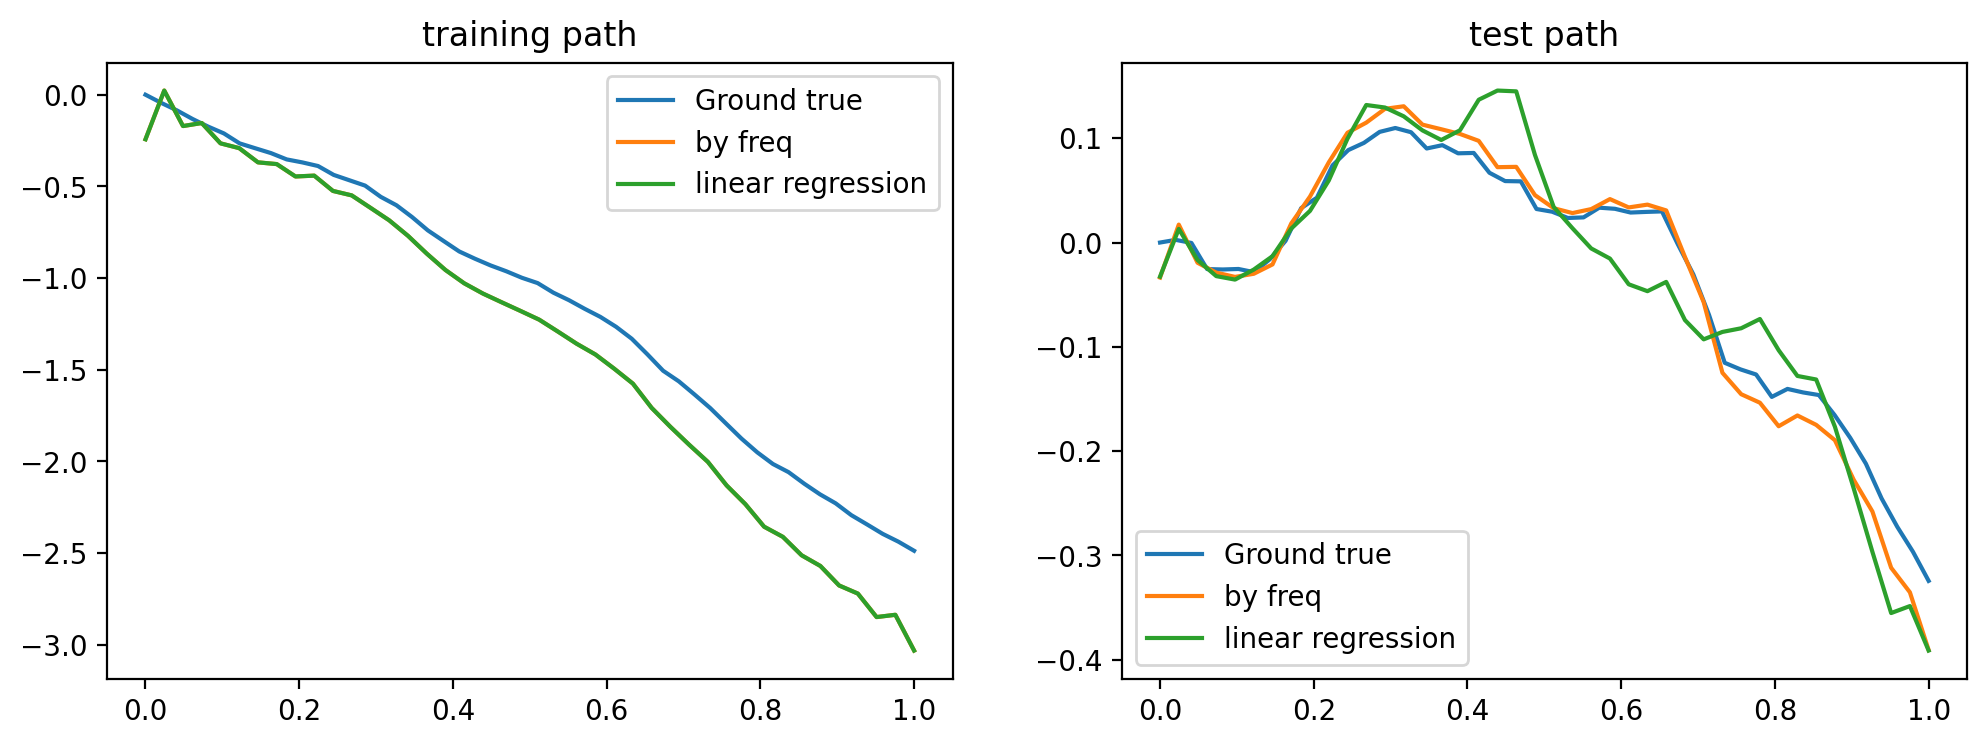

In [109]:
plt.figure(figsize=(12, 4), dpi=200)
plt.subplot(1, 2, 1)
plt.plot(torch.linspace(0, 1, len(example_path)), example_path, label='Ground true')
plt.plot(torch.linspace(0, 1, len(freq_path)), freq_path, label='by freq')
plt.plot(torch.linspace(0, 1, len(est_path)), est_path, label='linear regression')
plt.legend()
plt.title('training path')

plt.subplot(1, 2, 2)
plt.plot(torch.linspace(0, 1, len(test_path)), test_path, label='Ground true')
plt.plot(torch.linspace(0, 1, len(test_freq_path)), test_freq_path, label='by freq')
plt.plot(torch.linspace(0, 1, len(test_est_path)), test_est_path, label='linear regression')
plt.legend()
plt.title('test path')

#### Compare different parameters

In [112]:
n_list = torch.tensor([10, 50, 100, 200])
s_depth_list = torch.tensor([2, 6, 10, 14])
f_depth_list = torch.tensor([2, 20, 40, 90])
error_mat = torch.zeros((len(n_list), len(s_depth_list), len(f_depth_list)))

for i in range(len(n_list)):
    for j in tqdm.tqdm(range(len(s_depth_list))):
        for k in range(len(f_depth_list)):
            data = sig_Dataset(sample_num=sample_num,
                                    n=n_list[i].item(),
                                    hurst=hurst,
                                    f_depth=f_depth_list[k].item(),
                                    s_depth=s_depth_list[j].item())
            test_data = sig_Dataset(sample_num=sample_num,
                                    n=n_list[i].item(),
                                    hurst=hurst,
                                    f_depth=f_depth_list[k].item(),
                                    s_depth=s_depth_list[j].item())
            error_mat[i, j, k] = test_data.mse(A=data.A)

  0%|          | 0/4 [00:00<?, ?it/s]e:\File_VSCode\M3R\m3r_venv\lib\site-packages\fbm\fbm.py:171: UserWarning: Combination of increments n and Hurst value H invalid for Davies-Harte method. Reverting to Hosking method. Occurs when n is small and Hurst is close to 1. 
  warnings.warn(
100%|██████████| 4/4 [04:15<00:00, 63.79s/it]


In [115]:
print(error_mat[0])
print(error_mat[1])
print(error_mat[2])
print(error_mat[3])

tensor([[0.0120, 0.0052, 0.0056, 0.0052],
        [0.0008, 0.0054, 0.0037, 0.0147],
        [0.0027, 0.0298, 0.0061, 0.0080],
        [0.0057, 0.1143, 0.0444, 0.0184]])
tensor([[0.0665, 0.0083, 0.0064, 0.0064],
        [0.0057, 0.0104, 0.0106, 0.0092],
        [0.0064, 0.0211, 0.0736, 0.0486],
        [0.0531, 0.1455, 0.0571, 0.0391]])
tensor([[0.1426, 0.0180, 0.0085, 0.0062],
        [0.0091, 0.0201, 0.0074, 0.0297],
        [0.0896, 0.0862, 0.0130, 0.0262],
        [0.0448, 0.3350, 0.0126, 0.0364]])
tensor([[0.3168, 0.0340, 0.0183, 0.0076],
        [0.0326, 0.0362, 0.0219, 0.0080],
        [0.0661, 1.2310, 0.0582, 0.0093],
        [0.0685, 0.0524, 0.0390, 0.0574]])


In [116]:
# relation between n and s_depth when f_depth=40
print(error_mat[:, :, 2])

tensor([[0.0056, 0.0037, 0.0061, 0.0444],
        [0.0064, 0.0106, 0.0736, 0.0571],
        [0.0085, 0.0074, 0.0130, 0.0126],
        [0.0183, 0.0219, 0.0582, 0.0390]])


In [ ]:
## Linear model implementation
# class LinearRegressionModel(torch.nn.Module):
#     def __init__(self, in_channel, out_channel):
#         super(LinearRegressionModel, self).__init__()
#         self.linear = torch.nn.Linear(in_channel, out_channel)
 
#     def forward(self, x):
#         y_pred = self.linear(x)
#         return y_pred

# model = LinearRegressionModel(in_channel=data.inputs_dim, out_channel=data.labels_dim)
# criterion = torch.nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)

# for epoch in range(5000):
#     pred_y = model(data.inputs)
#     loss = criterion(pred_y, data.labels)
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#     if epoch%500==0:
#         print('epoch {}, loss {}'.format(epoch, loss.item()))

# with torch.no_grad():
#     example_sig, example_freq = data[4]
#     example_path = data.path[4]
#     freq_path = torch.fft.irfft(example_freq)
#     est_freq = model(example_sig).data
#     est_path = torch.fft.irfft(est_freq)